In [1]:
from pathlib import Path
import os
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import matplotlib.pyplot as plt
from common.helpers import get_roi_from_image
from common.constants import MOUTH

labels = os.listdir(r"data\train\mouth")
dataset_path = Path(r"data\train\mouth")
model_path_save = os.path.join('models')


In [19]:
# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path=os.path.join('models', 'blaze_face_short_range.tflite'))
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

def get_mouth_from_images():
    yawn_images = []
    annotated_images = []
    categories = ["no_yawn", "yawn"]
    for index, category in enumerate(categories):
        path_link = os.path.join(dataset_path, category)
        
        for image in os.listdir(path_link):
            image_path = os.path.join(path_link, image)
            image_cv2 = cv2.imread(image_path)
            gray_image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)
            
            image = mp.Image.create_from_file(image_path)
            detection_result = detector.detect(image)
            
            # STEP 5: Process the detection result. In this case, visualize it.
            # image_copy = np.copy(image.numpy_view())
            roi = get_roi_from_image(image_cv2, detection_result, keyponits=[MOUTH])
            yawn_images.append([gray_image[roi[MOUTH][0][1]: roi[MOUTH][1][1], roi[MOUTH][0][0]: roi[MOUTH][1][0]], index])
    return yawn_images

In [20]:
yawn_images = get_mouth_from_images()

In [21]:
yawn_images[0][0]

array([[155, 154, 153, ..., 212, 220, 193],
       [154, 153, 152, ..., 203, 202, 179],
       [153, 152, 151, ..., 196, 188, 170],
       ...,
       [142, 143, 144, ...,  41,  26,  12],
       [144, 144, 144, ...,  61,  46,  28],
       [134, 137, 140, ..., 125, 102,  51]], dtype=uint8)

# Save extracted mouth images

In [24]:
save_path = os.path.join('data', 'processed', 'mouth')

counter = 0
for img, img_class in yawn_images:
    if img_class == 0:
        no_yawn_path = os.path.join(save_path, 'no_yawn', str(counter) + '.jpg')
        cv2.imwrite(no_yawn_path, img)
    else:
        yawn_path = os.path.join(save_path, 'yawn', str(counter) + '.jpg')
        cv2.imwrite(yawn_path, img)    
    counter+=1

In [25]:
len(yawn_images)

1233

# Creating Model

In [46]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from common.constants import ROI_SIZES

batch_size = 32
img_width = ROI_SIZES[3][0][0] + ROI_SIZES[3][1][0]
img_height = ROI_SIZES[3][0][1] + ROI_SIZES[3][1][1]

mouth_data_dir = os.path.join('data', 'processed', 'mouth')

In [47]:
img_height, img_width

(90, 70)

In [48]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  mouth_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 1233 files belonging to 2 classes.
Using 987 files for training.


In [49]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  mouth_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 1233 files belonging to 2 classes.
Using 246 files for validation.


In [50]:
class_names = train_ds.class_names
print(class_names)

['no_yawn', 'yawn']


In [51]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 90, 70, 1)
(32,)


## Configuring dataset for performance

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarizing the data

In [53]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [54]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.18823531 0.8196079


# Creating keras model

In [55]:
from tensorflow.keras import layers
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 90, 70, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 70, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 35, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 35, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 17, 64)       

In [58]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


31/31 [==============================] - 3s 73ms/step - loss: 0.5129 - accuracy: 0.7528 - val_loss: 0.2021 - val_accuracy: 0.9431
Epoch 2/10
31/31 [==============================] - 2s 60ms/step - loss: 0.1965 - accuracy: 0.9271 - val_loss: 0.2302 - val_accuracy: 0.9024
Epoch 3/10
31/31 [==============================] - 2s 66ms/step - loss: 0.1582 - accuracy: 0.9504 - val_loss: 0.0840 - val_accuracy: 0.9715
Epoch 4/10
31/31 [==============================] - 2s 61ms/step - loss: 0.1240 - accuracy: 0.9574 - val_loss: 0.0902 - val_accuracy: 0.9756
Epoch 5/10
31/31 [==============================] - 2s 65ms/step - loss: 0.0922 - accuracy: 0.9726 - val_loss: 0.1069 - val_accuracy: 0.9675
Epoch 6/10
31/31 [==============================] - 2s 58ms/step - loss: 0.0800 - accuracy: 0.9737 - val_loss: 0.1692 - val_accuracy: 0.9634
Epoch 7/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0639 - accuracy: 0.9828 - val_loss: 0.0946 - val_accuracy: 0.9593
Epoch 8/10
31/31 [======

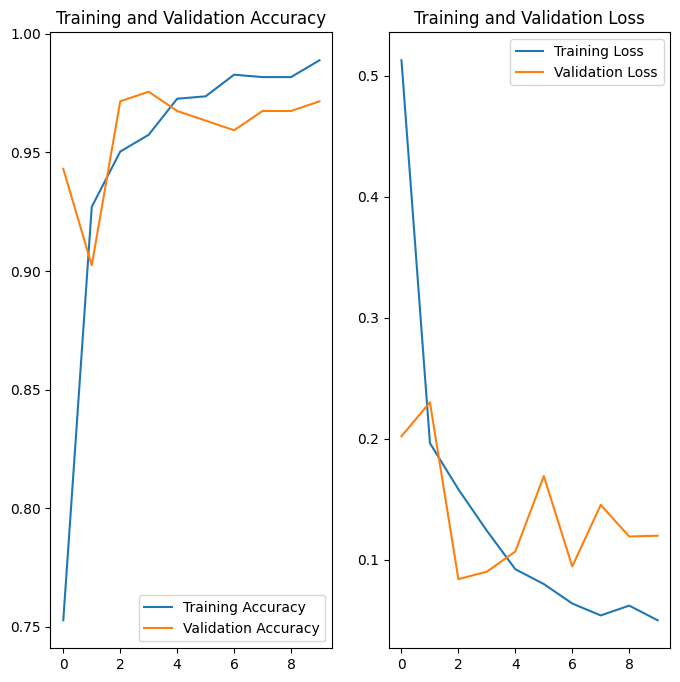

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
yawn_path = os.path.join('data', 'test', 'yawn')

yawn_images = []
IMG_SIZE = 145
categories = ["no_yawn", "yawn"]

test_dataset_path = os.path.join('data', 'test')
for index, category in enumerate(categories):
    path_link = os.path.join(test_dataset_path, category)
    
    for image in os.listdir(path_link):
        image_path = os.path.join(path_link, image)
        
        image = mp.Image.create_from_file(image_path)
        detection_result = detector.detect(image)
        
        image_cv2 = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)
        
        # STEP 5: Process the detection result. In this case, visualize it.
        roi = get_roi_from_image(image_cv2, detection_result, keyponits=[MOUTH])
        yawn_images.append([gray_image[roi[MOUTH][0][1]: roi[MOUTH][1][1], roi[MOUTH][0][0]: roi[MOUTH][1][0]], index])


In [61]:
accuracy = 0
for img, img_class in yawn_images:
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if (class_names[np.argmax(score)] == 'yawn' and img_class == 1) or (class_names[np.argmax(score)] == 'no_yawn' and img_class == 0):
        accuracy += 1

    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )

1/1 [==============================] - 0s 19ms/step


In [62]:
accuracy/len(yawn_images) * 100

98.13953488372093

In [ ]:
mouth_model_path = os.path.join(model_path_save, 'mouth_classification.keras')
model.save(mouth_model_path)

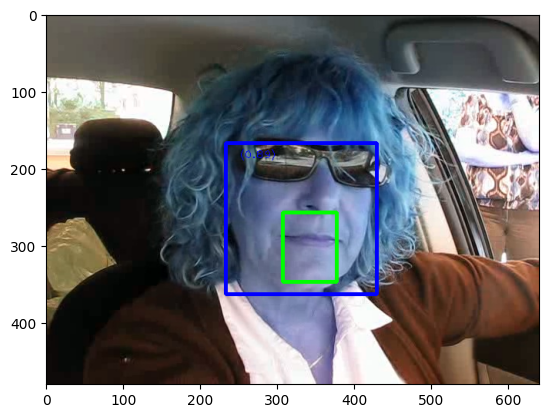

In [24]:
rgb_annotated_image = cv2.cvtColor(annotated_images[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb_annotated_image)

# Training model

In [39]:
X = []
y = []
for feature, label in yawn_images:
    X.append(feature)
    y.append(label)

In [44]:
yawn_images[0][0].shape

(90, 70, 3)

In [45]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [46]:
y = np.array(y)

# Train test split

In [47]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [48]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)


In [49]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [50]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\urzed\AppData\Local\Temp\ipykernel_7856\1487361493.py", line 1, in <module>
      history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Studia II\Master Thesis\Code\my_work\.venv\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 6144 values, but the requested shape requires a multiple of 1568
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_train_function_1066]

# Testing:

In [ ]:


haar_path = os.path.join('models', 'haar')
data_path = os.path.join('data', 'train')
labels = os.listdir(data_path)

import os

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path=os.path.join('models', 'blaze_face_short_range.tflite'))
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

IMAGE_FILE = os.path.join(data_path, "yawn", "6.jpg")
# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

In [8]:
from common.helpers import visualize

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image, detection = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
detection.keypoints

[NormalizedKeypoint(x=0.4321437180042267, y=0.4324796199798584, label='', score=0.0),
 NormalizedKeypoint(x=0.5396085381507874, y=0.4296240210533142, label='', score=0.0),
 NormalizedKeypoint(x=0.48219016194343567, y=0.5001121163368225, label='', score=0.0),
 NormalizedKeypoint(x=0.48382070660591125, y=0.575690507888794, label='', score=0.0),
 NormalizedKeypoint(x=0.37738099694252014, y=0.4794338345527649, label='', score=0.0),
 NormalizedKeypoint(x=0.60610431432724, y=0.4786100387573242, label='', score=0.0)]

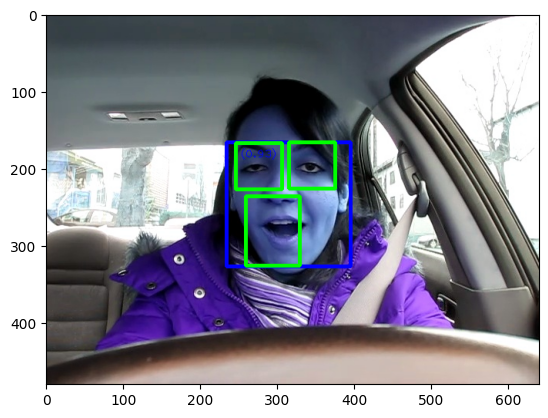

In [9]:
plt.imshow(rgb_annotated_image)